In [1]:
%cd ..
import jax.random as random
import matplotlib.pyplot as plt
from stencilnet.finite_volume import generate_rectilinear_mesh, u0, advection_solver
from stencilnet.model import init_mlp_params

%cd examples/

/Users/jonathan/Desktop/stencilNet
/Users/jonathan/Desktop/stencilNet/examples


In [2]:
# mlp
KEY = random.PRNGKey(1)

params = init_mlp_params(KEY, (9, 11, 4, 1))

I0000 00:00:1706533608.203179       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
# domain
n = 16
x, y = generate_rectilinear_mesh((0, 1), (0, 1), n)
u_init = u0(x, y, type="square")

In [4]:
# execute solver
U = advection_solver(
    u_init=u_init,
    h=(1 / n, 1 / n),
    v=(2, 1),
    T=1,
    cfl=0.8,
    p=3,
    forward="rk4",
    theta_limiting_params=params,
)

In [5]:
from jax import grad, jit
import jax.numpy as jnp


@jit
def loss(params):
    U = advection_solver(
        u_init=u_init,
        h=(1 / n, 1 / n),
        v=(2, 1),
        T=1,
        cfl=0.8,
        p=3,
        forward="rk4",
        theta_limiting_params=params,
    )
    err = jnp.sum(jnp.abs(U[-1] - U[0])) / n / n
    return err


grad(loss)(params)

[(Array([[0.00706652, 0.00708265, 0.0067566 , 0.00716333, 0.00717698,
          0.00683624, 0.00672282, 0.00672626, 0.00642019],
         [0.00706652, 0.00708265, 0.0067566 , 0.00716333, 0.00717698,
          0.00683624, 0.00672282, 0.00672626, 0.00642019],
         [0.00706652, 0.00708265, 0.0067566 , 0.00716333, 0.00717698,
          0.00683624, 0.00672282, 0.00672626, 0.00642019],
         [0.00706652, 0.00708265, 0.0067566 , 0.00716333, 0.00717698,
          0.00683624, 0.00672282, 0.00672626, 0.00642019],
         [0.00706652, 0.00708265, 0.0067566 , 0.00716333, 0.00717698,
          0.00683624, 0.00672282, 0.00672626, 0.00642019],
         [0.00706652, 0.00708265, 0.0067566 , 0.00716333, 0.00717698,
          0.00683624, 0.00672282, 0.00672626, 0.00642019],
         [0.00706652, 0.00708265, 0.0067566 , 0.00716333, 0.00717698,
          0.00683624, 0.00672282, 0.00672626, 0.00642019],
         [0.00706652, 0.00708265, 0.0067566 , 0.00716333, 0.00717698,
          0.00683624, 0.006

In [6]:
w0 = params[0][0]
w0.reshape(4, 3, 3)

TypeError: reshape total size must be unchanged, got new_sizes (4, 3, 3) for shape (11, 9).

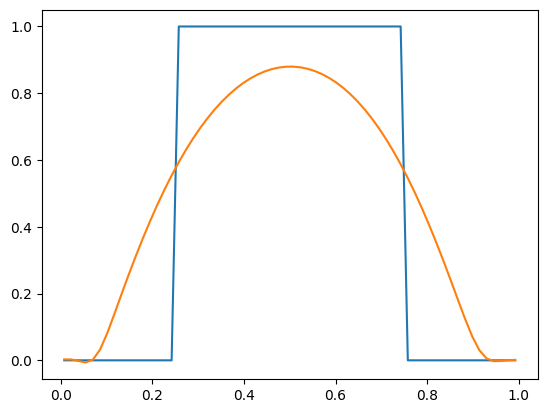

In [ ]:
# plot
plt.plot(x[0], U[0, int(n / 2), :])
plt.plot(x[0], U[-1, int(n / 2), :])
plt.show()